# Twitch Analysis

---

> **_Author:_** Yoann Poupart

---

The core of our project can be found [here](https://github.com/Xmaster6y/Twitch_Analysis) on Github. It contains the scripts used to gather data and convert them into graphs. It also contains a wide set of data enabling reproductibility of our work.

<mark>Before (re)-running/modifying the notebook be sure to clone the Github [repository](https://github.com/Xmaster6y/Twitch_Analysis) and unzip `images.zip` and `graphs.zip`</mark>

## From Data to Graph

The idea was to study the Twitch network for a given period of time. We are mainly interested in the communities and the hubs of this network

### Gathering Data

To gather data we overall used two similar ways. 
- The frist one was the use of the website [TwitchTracker]() which provides all information that we wanted. The problems were that the server was slow and sometimes didn't respond.
- The second way was to use the Twitch API. This is a really convenient API but limit request to 100 streams. This is plenty enough for statical analysis over time but could be a hindrance for precise dynamic analysis.

For the final analysis we decided to gather the data of the 100 top french streamers (and their viewers) every 15 minutes and for 1 day.

### Conversion into Graph

The first choice we made was to get rid of the viewers. Because keeping them would mean to have a bipartie graph and would make the analysis slightly more difficult. The second point was that viewers are not of great interest as regard of the network structure...
- This can cause a little loss of spatialisation, but at the end of the day the graph is far much easier to manipulate

As the viewers conveys the links between streams (and thus streamers), we decided to add weighted links between streamers where the weights were given by the number of common viewers between the streamers.

And to aggregate the data we decided to keep for each streamer a set of viewers that has ever watch the streamer over the period of time. 
- The bias here is that a viewer that watches a stream for 15 minutes and one that watches a stream for 2 hours will weight the same.

Hence, for the dynamic analysis we propose a slightly different approach. The main idea is to track the evolution of the network with the snapshots we gathered (every 15 minutes for 1 day).
- The counter part of taking truncated snapshots (only the top 100) is the oscillation of last streamers taken that will appear in and out of the network. This instability is caused by a little variation of the number of viewers. It is absorbed in the overall static analysis but not in the dynamic analysis. 


# Statical Analysis

Here the analysis focuses on link between streamers and communities.

## Library Imports

In [1]:
import json
import os
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from itertools import filterfalse

## Function Definitions

In [2]:
def relevance_filter(G, nodes_size=1000, link_rate=0.05, normalisation=True):
    """Reshape a graph by filtering the streamers that have less than 1000 viewers cumulated,
    and reweight the graph by w = # of viewers in common/min(# of viewers of streamer 1, # of viewers of streamer 2)
    then by filtering edges that have a weight inferior to 0.05. 
    Thus it means that there is a link between two streamers,
    if 5% of the smaller streamer viewers are also viewers of the bigger streamer. """
    G_filtered = cp.deepcopy(G)
    print(f"{len(G.nodes)} nodes")
    print(f"{len(G.edges)} edges")

    print("[INFO] filtering nodes")
    to_dump = filterfalse(lambda n:n[1]>nodes_size, G_filtered.nodes("viewers"))
    nodes_to_dump, _ = zip(*to_dump)
    G_filtered.remove_nodes_from(nodes_to_dump)

    print(f"{len(G.nodes)-len(G_filtered.nodes)} nodes removed")
    print(f"{len(G.edges)-len(G_filtered.edges)} edges removed")

    print("[INFO] filtering edges")
    f = lambda e:e[2]["weight"]/min(G_filtered.nodes[e[0]]["viewers"],G_filtered.nodes[e[1]]["viewers"])>link_rate
    to_dump = cp.deepcopy(list(filterfalse(f, G_filtered.edges.data())))
    G_filtered.remove_edges_from(list(to_dump))
    print(f"{len(G.edges)-len(G_filtered.edges)} edges removed")
    if normalisation:
        for streamer1, streamer2, data in G_filtered.edges.data():
            weight = data['weight']
            viewer_streamer_1 = G_filtered.nodes.data('viewers')[streamer1]
            viewer_streamer_2 = G_filtered.nodes.data('viewers')[streamer2]
            weight_norm = weight/min(viewer_streamer_1, viewer_streamer_2)
            data['weight'] = weight_norm
    return G_filtered

## Constant definitions

In [3]:
sub_base = "_1D"
base = "./Streamers_fr" + sub_base + "/"
viewers_file = "viewers.json"
graph_file = "./graphs/G_streamers_one_time_link_1D.graphml"

## Statistics Analysis

For this analysis we explore the data of a full day from 9h 5th of December 2021 to the 6th (9h).

We tried to explore the different characterisis of the graph. As we processed the graph before rendering it we explored the influence of such processing on the graph properties

In [4]:
G = nx.readwrite.graphml.read_graphml(graph_file)
G_filtered = relevance_filter(G)

753 nodes
206094 edges
[INFO] filtering nodes
520 nodes removed
180225 edges removed
[INFO] filtering edges
204401 edges removed


### Degree 

#### Without Filtering

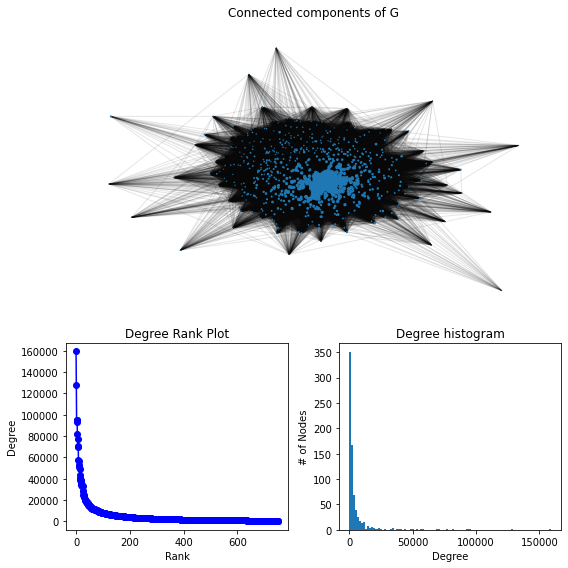

In [5]:
degree_sequence = sorted([d for n, d in G.degree(weight='weight')], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, weight='weight', seed=10396953)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
_, viewers_number = zip(*list(Gcc.nodes("viewers")))
scaled_viewers_number = list(map(lambda x:x/300, viewers_number))
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=scaled_viewers_number)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(degree_sequence, bins=100)
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

#### With Filtering

231


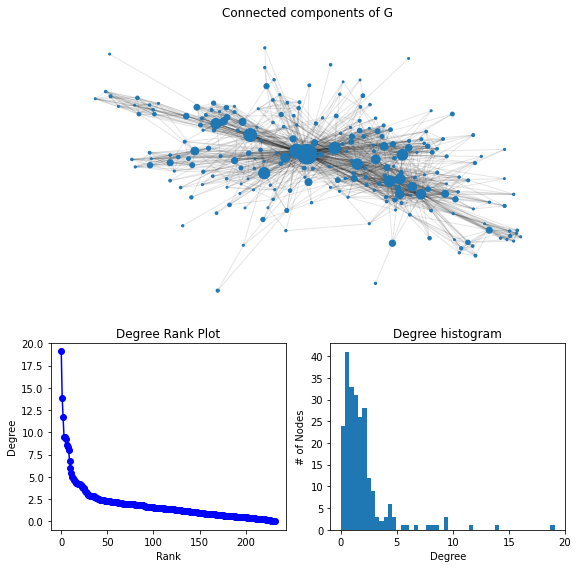

In [6]:
degree_sequence = sorted([d for n, d in G_filtered.degree(weight='weight')], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure(figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G_filtered.subgraph(sorted(nx.connected_components(G_filtered), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, weight='weight', seed=10396953)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
_, viewers_number = zip(*list(Gcc.nodes("viewers")))
scaled_viewers_number = list(map(lambda x:x/300, viewers_number))
print(len(scaled_viewers_number))
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=scaled_viewers_number)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(degree_sequence, bins=50)
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

#### Interpretation

We observe that the shapes of the degree-rank plot and the degree distribution are conserved with the filtering and normalisation. It is then keeping the main structure while becoming far much readable.

### Assortativity

#### Without Filtering

In [7]:
a1 = nx.algorithms.assortativity.degree_assortativity_coefficient(G, weight="weight")
a2 = nx.algorithms.assortativity.attribute_assortativity_coefficient(G, "viewers")
a3 = nx.algorithms.assortativity.numeric_assortativity_coefficient(G, "viewers")
a4 = nx.algorithms.assortativity.average_degree_connectivity(G, weight="weight")

degree_assortativity_coefficient : -0.014267971271065362
attribute_assortativity_coefficient : -0.0013754749578557966
numeric_assortativity_coefficient : -0.009911478270805477


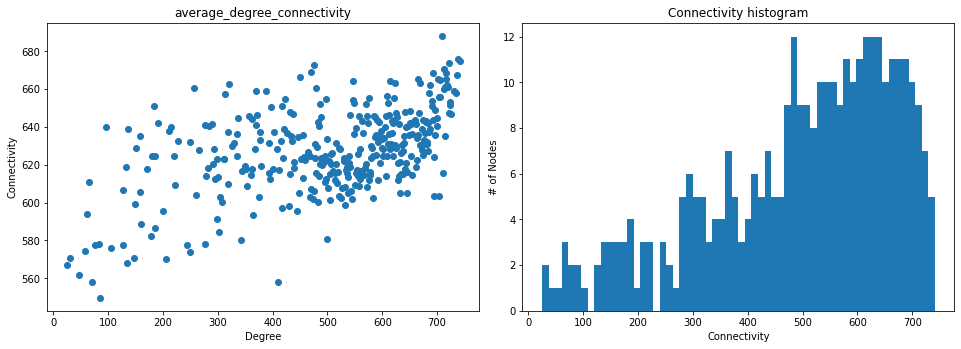

In [8]:
print(f"degree_assortativity_coefficient : {a1}\n\
attribute_assortativity_coefficient : {a2}\n\
numeric_assortativity_coefficient : {a3}")

fig = plt.figure()
degrees = sorted(a4.keys())
ax = fig.add_axes([0,0,1,1])
ax.scatter(degrees, [a4[degree] for degree in degrees])
ax.set_title("average_degree_connectivity")
ax.set_xlabel("Degree")
ax.set_ylabel("Connectivity")

ax = fig.add_axes([1.1,0,1,1])
ax.hist(a4, bins=60)
ax.set_title("Connectivity histogram")
ax.set_xlabel("Connectivity")
ax.set_ylabel("# of Nodes")

plt.show()

#### With Filtering

In [9]:
a1 = nx.algorithms.assortativity.degree_assortativity_coefficient(G_filtered, weight="weight")
a2 = nx.algorithms.assortativity.attribute_assortativity_coefficient(G_filtered, "viewers")
a3 = nx.algorithms.assortativity.numeric_assortativity_coefficient(G_filtered, "viewers")
a4 = nx.algorithms.assortativity.average_degree_connectivity(G_filtered, weight="weight")

degree_assortativity_coefficient : -0.2936018931033102
attribute_assortativity_coefficient : -0.012213309130847044
numeric_assortativity_coefficient : -0.22417407421479563


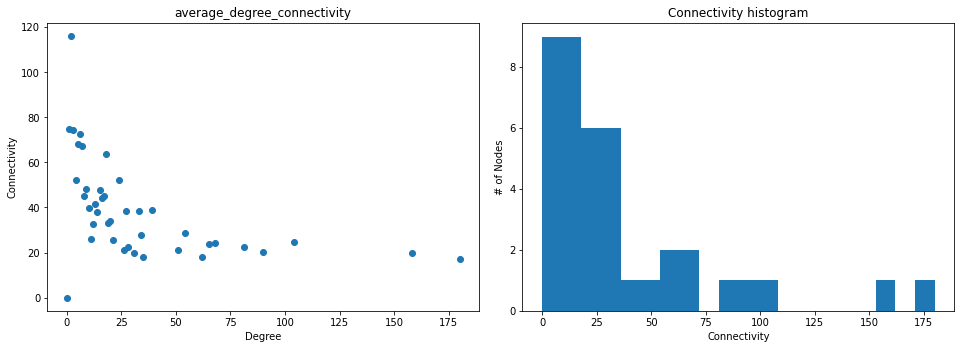

In [10]:
print(f"degree_assortativity_coefficient : {a1}\n\
attribute_assortativity_coefficient : {a2}\n\
numeric_assortativity_coefficient : {a3}")

fig = plt.figure()
degrees = sorted(a4.keys())
ax = fig.add_axes([0,0,1,1])
ax.scatter(degrees, [a4[degree] for degree in degrees])
ax.set_title("average_degree_connectivity")
ax.set_xlabel("Degree")
ax.set_ylabel("Connectivity")

ax = fig.add_axes([1.1,0,1,1])
ax.hist(a4, bins=20)
ax.set_title("Connectivity histogram")
ax.set_xlabel("Connectivity")
ax.set_ylabel("# of Nodes")

plt.show()

#### Interpretation

We observe a loss of connectivity and assortativity. The filtered network is now way more sparse. As we are more interested in qualitative interpretations this is not problematic here. Yet, if one would want to do quantitative calculation, it could be better to keep the originl graph.

### Betweeness Centrality and Community

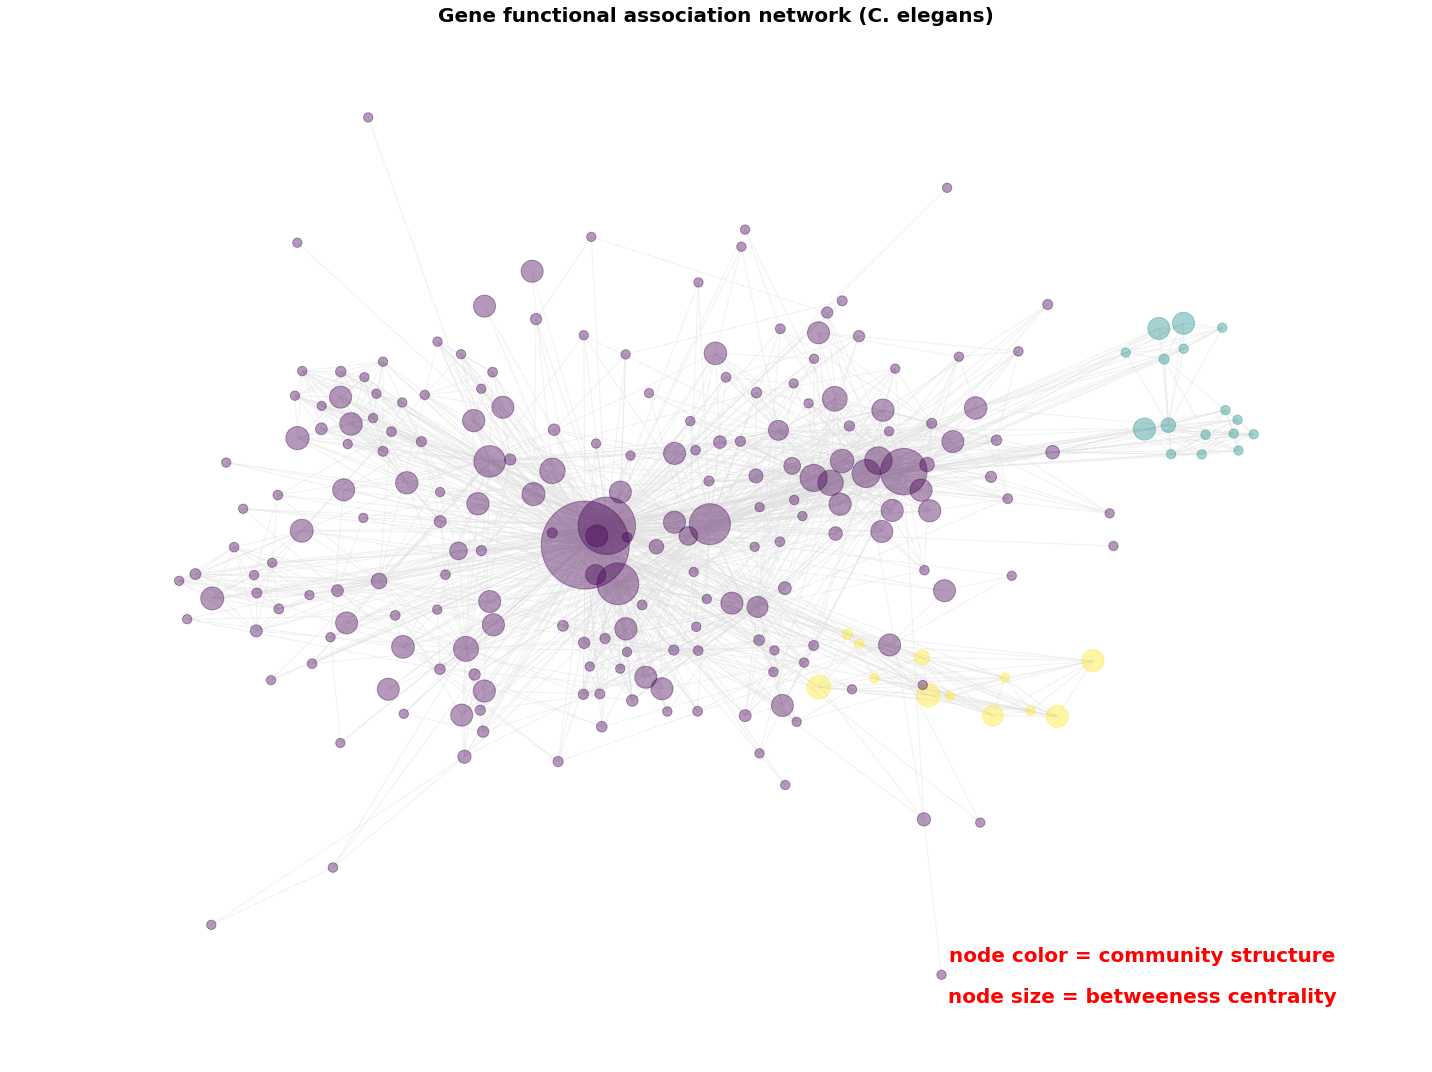

In [11]:

components = nx.connected_components(G_filtered)
largest_component = max(components, key=len)
H = G_filtered.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=50, weight='weight', endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

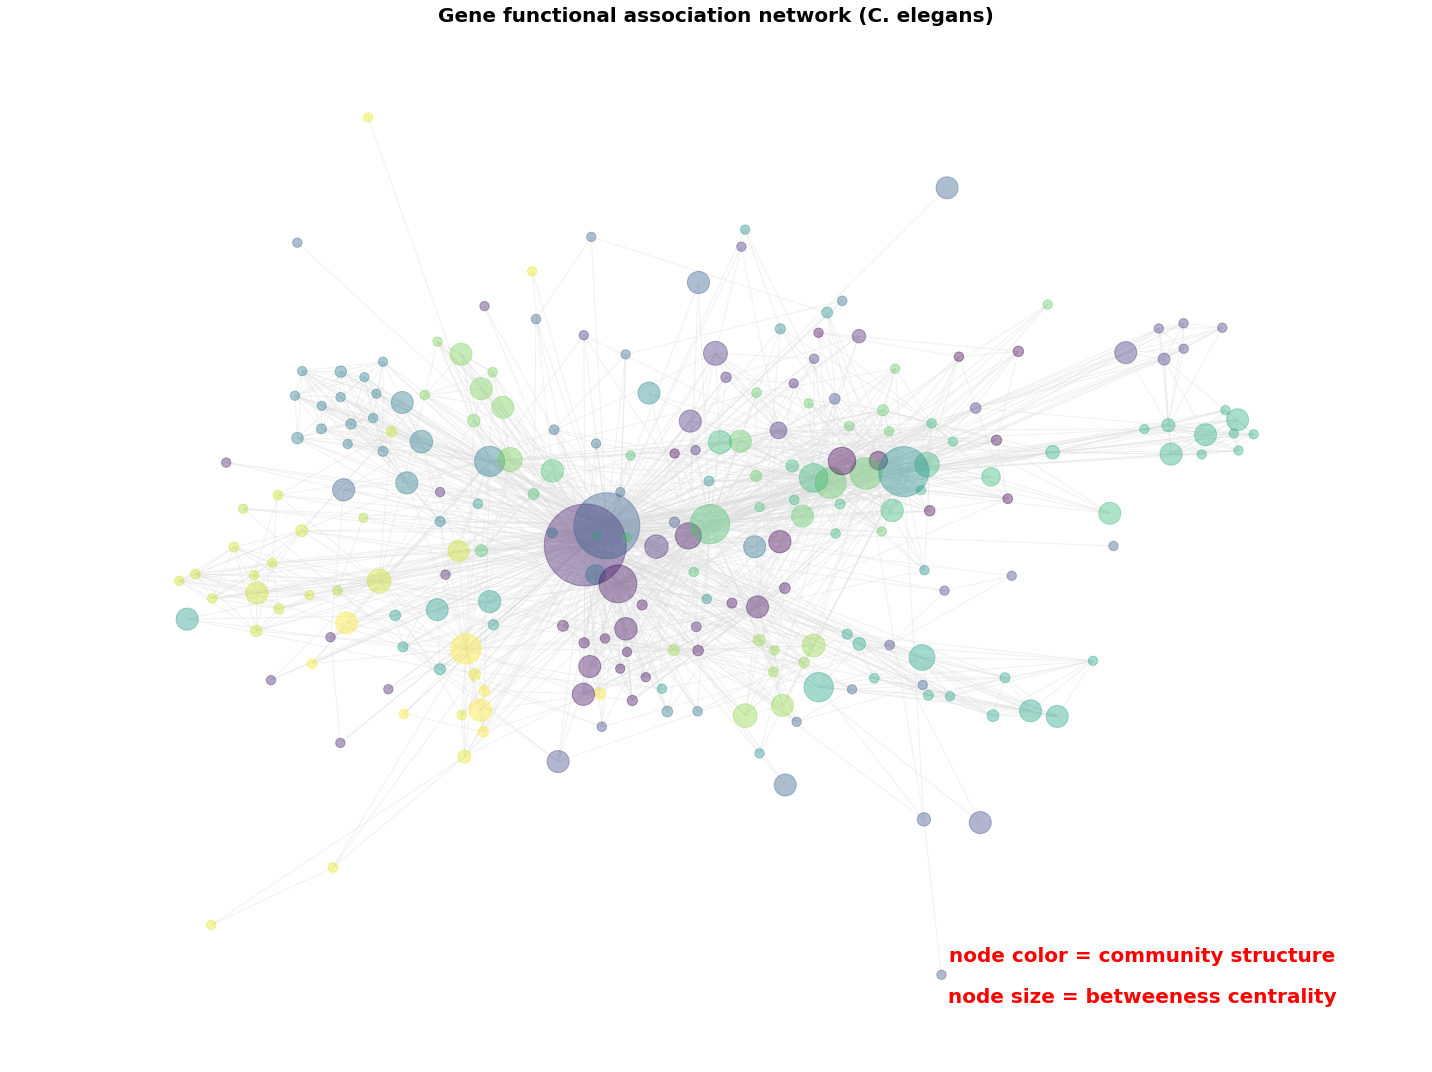

In [12]:

components = nx.connected_components(G_filtered)
largest_component = max(components, key=len)
H = G_filtered.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=50, weight='weight', endpoints=True)

# compute community structure
lpc = nx.community.asyn_fluidc(H,k=25)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

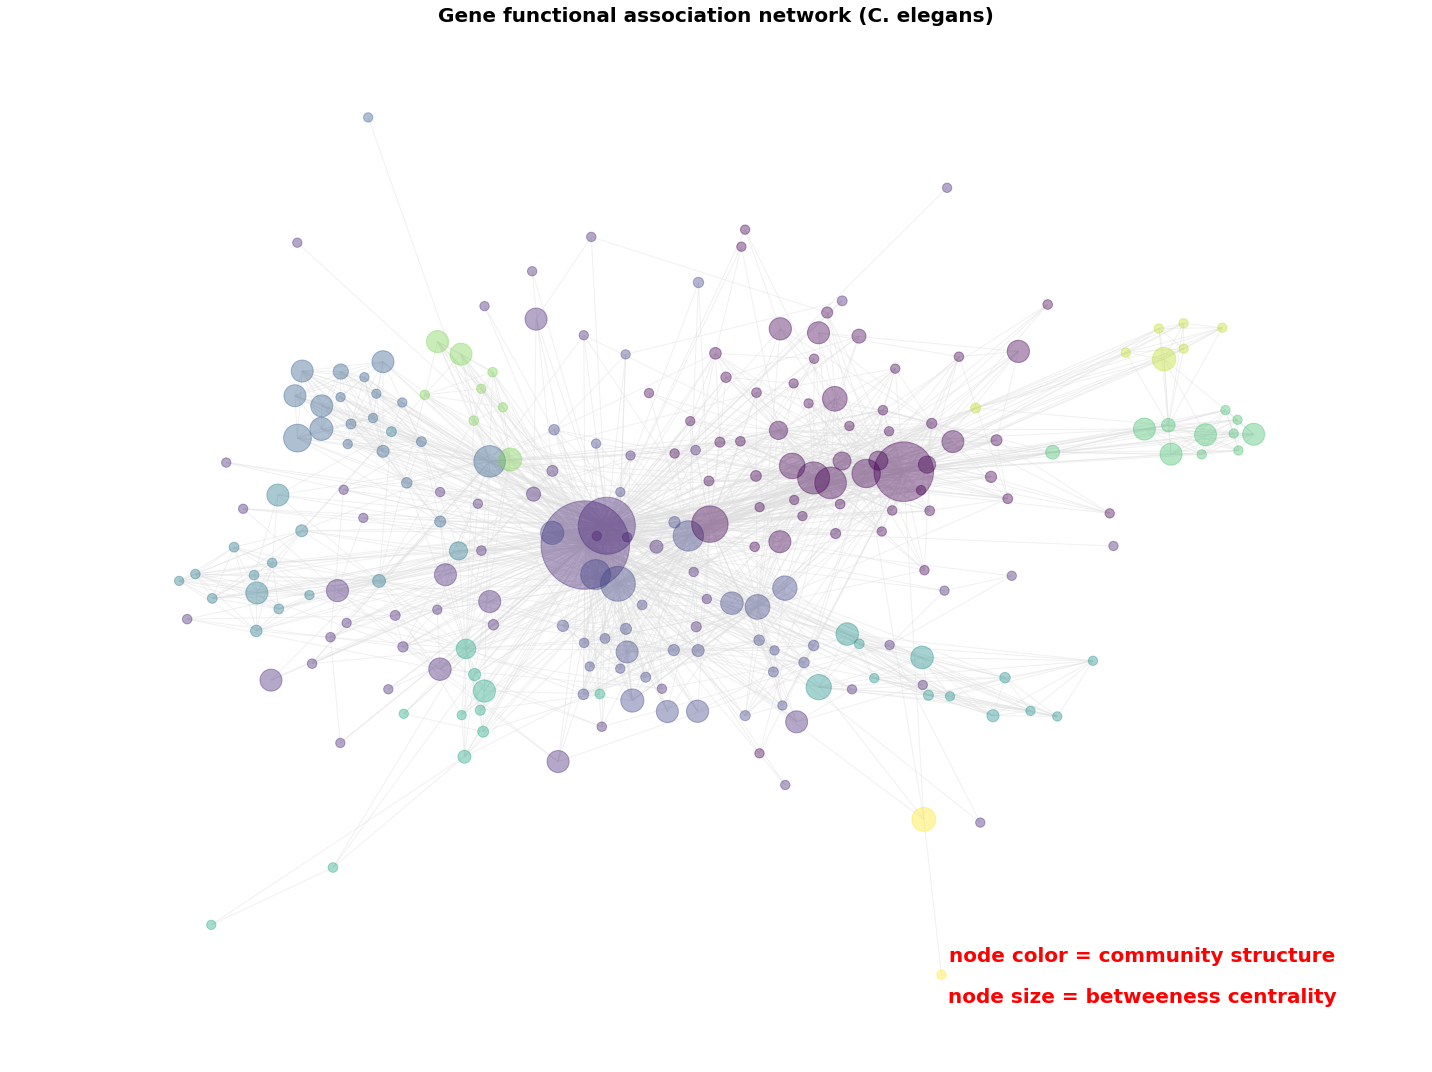

In [13]:

components = nx.connected_components(G_filtered)
largest_component = max(components, key=len)
H = G_filtered.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=50, weight='weight', endpoints=True)

# compute community structure
lpc = nx.community.greedy_modularity_communities(H,weight="weight")
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

#### Interpretation

It is interesting here to see that the label propagation totaly fails to recover the communities comparing to the other methods. For this method further filtering could be needed.

The `greedy_modularity_communities` algorithm retrieve some of the isolated communities, but fails to differenciate in the middle. It could be due to the high connectivity of the communities in this area, the <mark>Main Stream Communities</mark>.

The `asyn_fluidc` has better performance but with a prior knowledge of the number of communities we want to observe (see the section below).

Further work could be to quantitativaly investigate these performances as regard to the labels. We can expect to have some communities that are not separable (main stream communities) and other that are fragmented (like GTA or Just Chatting)

## Graphical Representation

### Gephi Representation

Here we used a the topics of the streams that we gather along with the viewers to improve the visualisation. This representation is made on the filtered graph, see the section above.

From 9/12/2021-8h26 to 10/12/2021-8h11 

![Final Graph](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/1D.png)

### Legend

Here is a legend that holds for all the `Gephi` images:
![Legend](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/legend.png)

## Week Snapshots

Due to a server issue we only have 4 full days.

The first graph was made from the data gathered from (Saturday)11/12/2021-15h37 to 12/12/2021-15h22:
![First Day](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/1W_D0.png)
The first graph was made from the data gathered from (Sunday)12/12/2021-15h37 to 13/12/2021-15h22:
![Second Day](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/1W_D1.png)
The first graph was made from the data gathered from (Monday)13/12/2021-15h37 to 14/12/2021-15h22:
![Third Day](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/1W_D2.png)
The first graph was made from the data gathered from (Tuesday)14/12/2021-15h37 to 15/12/2021-15h22:
![Fourth Day](https://raw.githubusercontent.com/Xmaster6y/Twitch_Analysis/main/images/1W_D3.png)

### Interpretation

The first thing to notice is that the layout and the filtering/normalisation applied capture the community links.

Then for the week snapshots we see that Saturday/Sunday are quite diffrent from Monday/Tuesday from the structural point of view. This was predictible but it can be refined by digging each day. In fact we directly observe that Sunday has a lot of big streamers -> Most people have more time on Sunday.

For the week dynamic we can see the difference of structure and among the streamers. Some streamers/subjects remain of the same shape during the week (the regulars (daily frequency)), some appear (like squeezie and domingo) on certain days (weekly frequency). By heuristic knowledge, most of the channels have at most weekly frequency (apart from rare events like Z-event)

From these graph we can obtain link information between different communities. If we take 4 different games (FIFA, Pokemon, Call-of-Duty, GTA) we observe very different spatialisation. FIFA and GTA communities are much more isolated than Call-of-Duty and GTA ones. For Pokemon this is representative of broadness of players, for Call-of-Duty this is also the case but can be biased by the "big streamers"/hubs integrating the community. 

# Hour Dynamic

We inspect here the "dynamic" at an hour scale. The word "dynamic" refers here has the dynamic of the link creation for the graphs represented above, forgetting all that came before.

## Defining Functions

In [14]:
def degree_distribution(G):
    L_degree = np.array([])
    for streamer, data in G.degree():
        L_degree = np.append(L_degree, data)
    return(L_degree)

def viewers_distribution(G):
    L_viewers = np.array([])
    for streamer, data in G.nodes.data():
        if len(data) == 2:
            viewer, subject = data['viewers'], data['subject']
            L_viewers = np.append(L_viewers, viewer)
    return(L_viewers)
            
def modularity_communities_games(G):
    """Allows to calculate the communities of a graph based on a selection of games,
    then it is possible to calculate the modularity of this communities."""
    if G == L_graph_2[0]:
        return(0)
    else:
        L_name_games = np.array(['Teamfight Tactics', 'FIFA 22', 'Just Chatting', 'Pokémon Brilliant Diamond/Shining Pearl', 'Fortnite', 'Call of Duty: Warzone', 'VALORANT', 'League of Legends', 'Dead by Daylight', 'Apex Legends', 'Minecraft', 'Grand Theft Auto V', 'Age of Empires IV', 'Rocket League', "Sid Meier's Civilization VI", 'Counter-Strike: Global Offensive', 'Talk Shows & Podcasts'])
        L_community = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
        print(L_community[0])
        n = len(L_name_games)
        for streamer, data in G.nodes.data():
            if len(data) == 2:
                viewer, subject = data['viewers'], data['subject']
                if (L_name_games==subject).any() == True: 
                    a = np.where(L_name_games==subject)[0][0]
                    L_community[a].append(streamer)
                else :
                    L_community[n].append(streamer)
            else:
                L_community[n].append(streamer)

        return(nx_comm.modularity(G, L_community))

## Loading Graphs

In [15]:
L_graph = []
L_graph_2 = []
for i in range (0,24):
    if i < 10:
        name_graph = 'G_streamers_one_time_link_1D_H0'+str(i)+'.graphml'
    else : 
        name_graph = 'G_streamers_one_time_link_1D_H'+str(i)+'.graphml'
    g = nx.read_graphml('./graphs/'+name_graph)
    L_graph.append(g)
    L_graph_2.append(relevance_filter(g))

145 nodes
4500 edges
[INFO] filtering nodes
139 nodes removed
4486 edges removed
[INFO] filtering edges
4500 edges removed
186 nodes
8207 edges
[INFO] filtering nodes
171 nodes removed
8108 edges removed
[INFO] filtering edges
8201 edges removed
215 nodes
11597 edges
[INFO] filtering nodes
191 nodes removed
11340 edges removed
[INFO] filtering edges
11574 edges removed
249 nodes
16202 edges
[INFO] filtering nodes
220 nodes removed
15823 edges removed
[INFO] filtering edges
16157 edges removed
270 nodes
19750 edges
[INFO] filtering nodes
227 nodes removed
18892 edges removed
[INFO] filtering edges
19668 edges removed
304 nodes
25049 edges
[INFO] filtering nodes
250 nodes removed
23684 edges removed
[INFO] filtering edges
24935 edges removed
335 nodes
31121 edges
[INFO] filtering nodes
271 nodes removed
29216 edges removed
[INFO] filtering edges
30949 edges removed
357 nodes
36278 edges
[INFO] filtering nodes
279 nodes removed
33426 edges removed
[INFO] filtering edges
36032 edges remove

## Analysis

In [16]:
T = np.arange(0,24)
L_nb_nodes = []
L_nb_edges = []
L_density = []
L_transitivity = []
L_mean_degree = []
L_max_degree = []
L_diameter = []
L_modularity = []
L_ASPL = []
L_mean_viewer = [] 
L_max_viewer = []
L_nb_nodes_2 = []
L_nb_edges_2 = []
L_density_2 = []
L_transitivity_2 = []
L_mean_degree_2 = []
L_max_degree_2 = []
L_diameter_2 = []
L_modularity_2 = []
L_ASPL_2 = []
L_mean_viewer_2 = [] 
L_max_viewer_2 = []
for i in L_graph:
    print(i)
    L_nb_nodes.append(len(i.nodes()))
    L_nb_edges.append(len(i.edges()))
    L_density.append(nx.density(i))
    L_mean_degree.append(np.mean(degree_distribution(i)))
    L_max_degree.append(np.max(degree_distribution(i)))
    L_diameter.append(nx.diameter(i))
    L_transitivity.append(nx.transitivity(i))
    L_modularity.append(modularity_communities_games(i))
    L_ASPL.append(nx.average_shortest_path_length(i))
    L_mean_viewer.append(np.mean(viewers_distribution(i)))
    L_max_viewer.append(np.max(viewers_distribution(i)))
for i in L_graph_2:
    print(i)
    L_nb_nodes_2.append(len(i.nodes()))
    L_nb_edges_2.append(len(i.edges()))
    L_density_2.append(nx.density(i))
    L_mean_degree_2.append(np.mean(degree_distribution(i)))
    L_max_degree_2.append(np.max(degree_distribution(i)))
    L_diameter_2.append(nx.diameter(i.subgraph(sorted(nx.connected_components(i), key=len, reverse=True)[0])))
    L_transitivity_2.append(nx.transitivity(i))
    L_modularity_2.append(modularity_communities_games(i))
    L_ASPL_2.append(nx.average_shortest_path_length(i.subgraph(sorted(nx.connected_components(i), key=len, reverse=True)[0])))
    L_mean_viewer_2.append(np.mean(viewers_distribution(i)))
    L_max_viewer_2.append(np.max(viewers_distribution(i)))

Graph with 145 nodes and 4500 edges
[]
Graph with 186 nodes and 8207 edges
[]
Graph with 215 nodes and 11597 edges
[]
Graph with 249 nodes and 16202 edges
[]
Graph with 270 nodes and 19750 edges
[]
Graph with 304 nodes and 25049 edges
[]
Graph with 335 nodes and 31121 edges
[]
Graph with 357 nodes and 36278 edges
[]
Graph with 382 nodes and 42062 edges
[]
Graph with 421 nodes and 51223 edges
[]
Graph with 443 nodes and 57633 edges
[]
Graph with 475 nodes and 66571 edges
[]
Graph with 498 nodes and 73621 edges
[]
Graph with 514 nodes and 79669 edges
[]
Graph with 541 nodes and 88120 edges
[]
Graph with 566 nodes and 95426 edges
[]
Graph with 591 nodes and 102350 edges
[]
Graph with 608 nodes and 109359 edges
[]
Graph with 632 nodes and 117758 edges
[]
Graph with 658 nodes and 126283 edges
[]
Graph with 682 nodes and 134363 edges
[]
Graph with 726 nodes and 149461 edges
[]
Graph with 745 nodes and 156602 edges
[]
Graph with 753 nodes and 160548 edges
[]
Graph with 6 nodes and 0 edges
Gra

## Plot of the Data

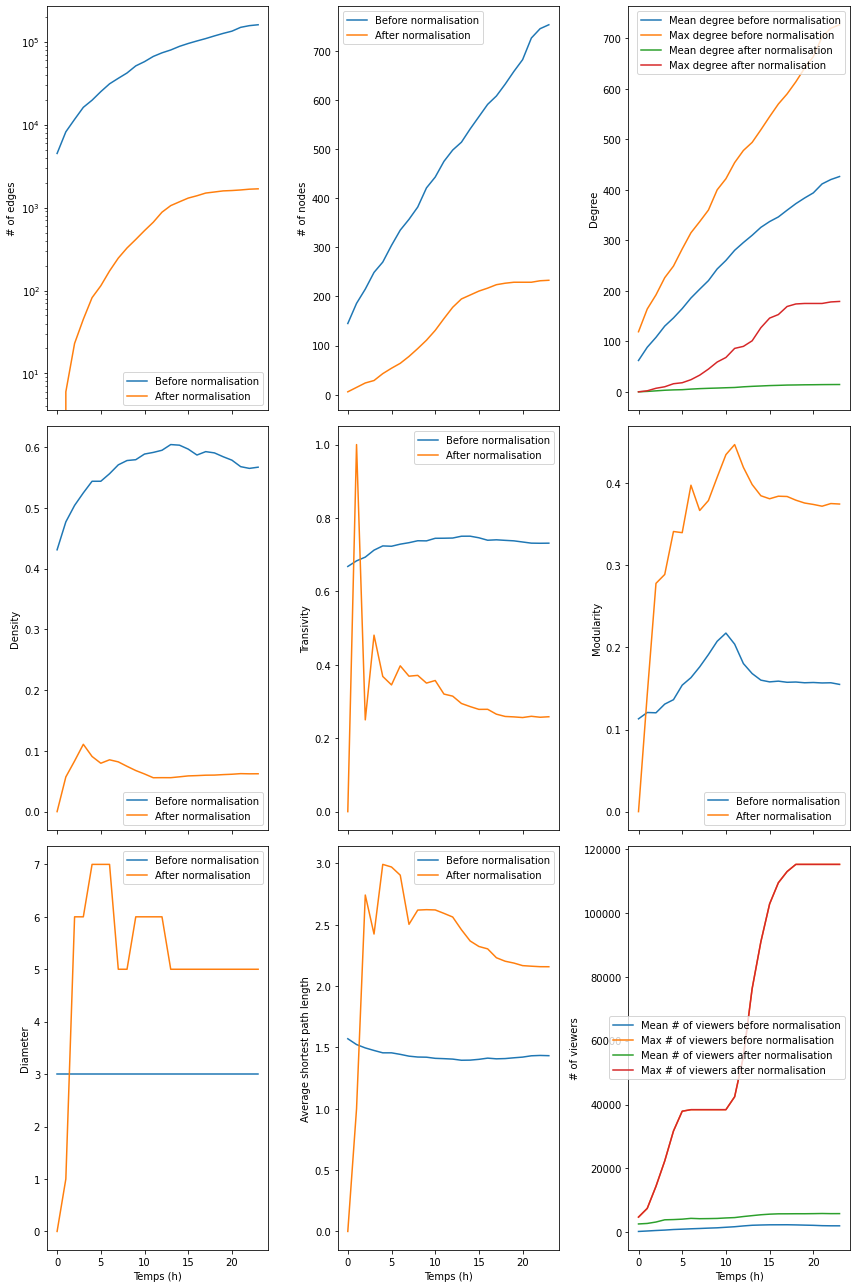

In [17]:
fig, ax = plt.subplots(3,3, sharex = True, figsize = (12,18), tight_layout=True) #
#Before Normalisation
ax[0,0].plot(T, L_nb_edges, label='Before normalisation')
ax[0,1].plot(T, L_nb_nodes, label='Before normalisation')
ax[0,2].plot(T, L_mean_degree, label='Mean degree before normalisation')
ax[0,2].plot(T, L_max_degree, label='Max degree before normalisation')
ax[1,0].plot(T, L_density, label='Before normalisation')
ax[1,1].plot(T, L_transitivity, label='Before normalisation')
ax[1,2].plot(T, L_modularity, label='Before normalisation')
ax[2,0].plot(T, L_diameter, label='Before normalisation')
ax[2,1].plot(T, L_ASPL, label='Before normalisation')
ax[2,2].plot(T, L_mean_viewer, label='Mean # of viewers before normalisation')
ax[2,2].plot(T, L_max_viewer, label='Max # of viewers before normalisation')
#After normalisation
ax[0,0].plot(T, L_nb_edges_2, label='After normalisation')
ax[0,1].plot(T, L_nb_nodes_2, label='After normalisation')
ax[0,2].plot(T, L_mean_degree_2, label='Mean degree after normalisation')
ax[0,2].plot(T, L_max_degree_2, label='Max degree after normalisation')
ax[1,0].plot(T, L_density_2, label='After normalisation')
ax[1,1].plot(T, L_transitivity_2, label='After normalisation')
ax[1,2].plot(T, L_modularity_2, label='After normalisation')
ax[2,0].plot(T, L_diameter_2, label='After normalisation')
ax[2,1].plot(T, L_ASPL_2, label='After normalisation')
ax[2,2].plot(T, L_mean_viewer_2, label='Mean # of viewers after normalisation')
ax[2,2].plot(T, L_max_viewer_2, label='Max # of viewers after normalisation')
#Graphs 
ax[0,0].set_ylabel('# of edges')
ax[0,1].set_ylabel('# of nodes')
ax[0,2].set_ylabel('Degree')
ax[1,0].set_ylabel('Density')
ax[1,1].set_ylabel('Transivity')
ax[1,2].set_ylabel('Modularity')
ax[2,0].set_ylabel('Diameter')
ax[2,1].set_ylabel('Average shortest path length')
ax[2,2].set_ylabel('# of viewers')
ax[0,0].set_yscale('log')
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
ax[2,0].legend()
ax[2,1].legend()
ax[2,2].legend()
ax[2,0].set_xlabel('Temps (h)') 
ax[2,1].set_xlabel('Temps (h)') 
ax[2,2].set_xlabel('Temps (h)') 
plt.show()

## Interpretation

The main goal here is both to observe the evolution in time of different metrics that decribes the graph and to quantify the impact of the remodeling of the graph by our method. 

Thus, we plot the number of nodes, edges, viewers, the degree, the density, the transivity, the modularity, the diameter and the average shortest path length in function of the time and so before and after reshaping the graphs.
First qualitatively, the running time is considerably lower with the reshaped graphs this comes from the number of edge that is also considerably lower (from 3 to 2 orders of magnitude lower). By reducing the number of edges, the density of the graph is also a lot reduced and the diameter and the average shortest path legnth is increased. Those 2 metrics tends to converge each on the same value. We see that the transitivity is quite lowered by the reshaping.

Modularity where communities are computed by game labeling shows that the reshaping is increasing a lot the modularity and so creates more coherent communities.

# Dynamical Analysis

We propose a short alternative kind of analysis. The new analysis is made from the viewer point of view. The user data are more susceptible to vary over time than the streamer data.  

The data was a bit modified:
- We only kept viewer that watch only one stream at a time 
    - We are interested in movement/flux of the viewer(s)
    - We didn't wanted to treat non-deterministic walk (two place at a time for example)
- We focused on the viewer side
    - The nodes are still streamers
    - The edges are created based on walks (change of channels)
- What is it to discover?
    - Viewer classification to illustrate different behaviours
    - Audience analysis
    
We also propose three euristics to differentiate viewers:
- Fidelity
    $$F_{chan} = \dfrac{watch\_time\_chan}{chan\_stream\_time}$$ 
    Super fidel = Watching a channel whennever it's streaming
- Passion
    $$P_{com} = \dfrac{watch\_time\_com}{watch\_time}$$ 
    Super passionate = Watching only a kind of stream (exception for "just chatting")
- Curiosity
    $$C = \min(1, \alpha\dfrac{N_{chan\_visited}\times interval}{watch\_time})$$ 
    Super curious = Watching a different channel each time ($\alpha$ is the normalisation constant).
    
## Defining Constants

In [18]:
pre_base = "graphs/"
sub_base = "_1D"
base = "./Streamers_fr" + sub_base + "/"
viewers_file = "viewers.json"

## Defining Functions

In [19]:
def fidelity(viewer_watch_list, streamer, stream_time): 
    return viewer_watch_list.count(streamer)/stream_time[streamer]
    
def passion(viewer_watch_list, subject, subjects, remove_chatting=True):
    viewer_watch_subjects = list(map(lambda s:subjects[s], viewer_watch_list))
    if remove_chatting:
        return viewer_watch_subjects.count(subject)/(len(viewer_watch_list)-viewer_watch_subjects.count("Just Chatting"))
    return viewer_watch_subjects.count(subject)/len(viewer_watch_list)
    
def curiosity(viewer_watch_list, alpha=1):
    c = alpha*len(set(viewer_watch_list))/len(viewer_watch_list)
    return min(1, c)

def audience_stats(compared_streamers, stream_time, all_time_viewer_watch_lists, subjects):
    data = {streamer:{"fidelity" : [],
                  "passion" : [],
                  "curiosity" : []} for streamer in compared_streamers}

    for viewer, viewer_watch_list in all_time_viewer_watch_lists.items():
        for streamer in compared_streamers:
            if streamer in viewer_watch_list:
                subject = subjects[streamer]
                f = fidelity(viewer_watch_list, streamer, stream_time)
                data[streamer]["fidelity"].append(f)
                if subject == "Just Chatting":
                    p = passion(viewer_watch_list, subject, subjects, remove_chatting=False)
                else:
                    p = passion(viewer_watch_list, subject, subjects)
                data[streamer]["passion"].append(p)
                c = curiosity(viewer_watch_list)
                data[streamer]["curiosity"].append(c)  
    return data

def relevance_filter_directed(G, nodes_size=500, link_rate=5e-4):  
    G_filtered = cp.deepcopy(G)
    print(f"{len(G.nodes)} nodes")
    print(f"{len(G.edges)} edges")

    print("[INFO] filtering nodes")
    to_dump = filterfalse(lambda n:n[1]>nodes_size, G_filtered.nodes("watched_time"))
    nodes_to_dump, _ = zip(*to_dump)
    G_filtered.remove_nodes_from(nodes_to_dump)

    print(f"{len(G.nodes)-len(G_filtered.nodes)} nodes removed")
    print(f"{len(G.edges)-len(G_filtered.edges)} edges removed")

    print("[INFO] filtering edges")
    f = lambda e:e[2]["change"]/G_filtered.nodes[e[1]]["watched_time"]>link_rate
    to_dump = cp.deepcopy(list(filterfalse(f, G_filtered.edges.data())))
    G_filtered.remove_edges_from(list(to_dump))
    print(f"{len(G.edges)-len(G_filtered.edges)} edges removed")
    return G_filtered

## Loading Graph and Objects

In [20]:
G = nx.readwrite.graphml.read_graphml("graphs/G_streamers_watch_time_link_1D.graphml")
with open("graphs/streamers_watch_time_link_1D_ST", "r") as file:
    stream_time = json.load(file)
with open("graphs/streamers_watch_time_link_1D_WT", "r") as file:
    all_time_viewer_watch_lists = json.load(file)
with open("graphs/streamers_watch_time_link_1D_sub", "r") as file:
    subjects = json.load(file)
    
## It takes time so run if really needed
#streamers = list(set(sum(all_time_viewer_watch_lists.values(), start=[])))

## Audience Analysis

### Comparison  Between Streamers

In [21]:
compared_streamers = ["domingo", "gotaga", "zerator", "ponce", "dokhy"]
data = audience_stats(compared_streamers, stream_time, all_time_viewer_watch_lists, subjects)
average_data = [
                [np.mean(data[streamer][q]) for streamer in compared_streamers] 
                for q in data[compared_streamers[0]].keys()
               ]

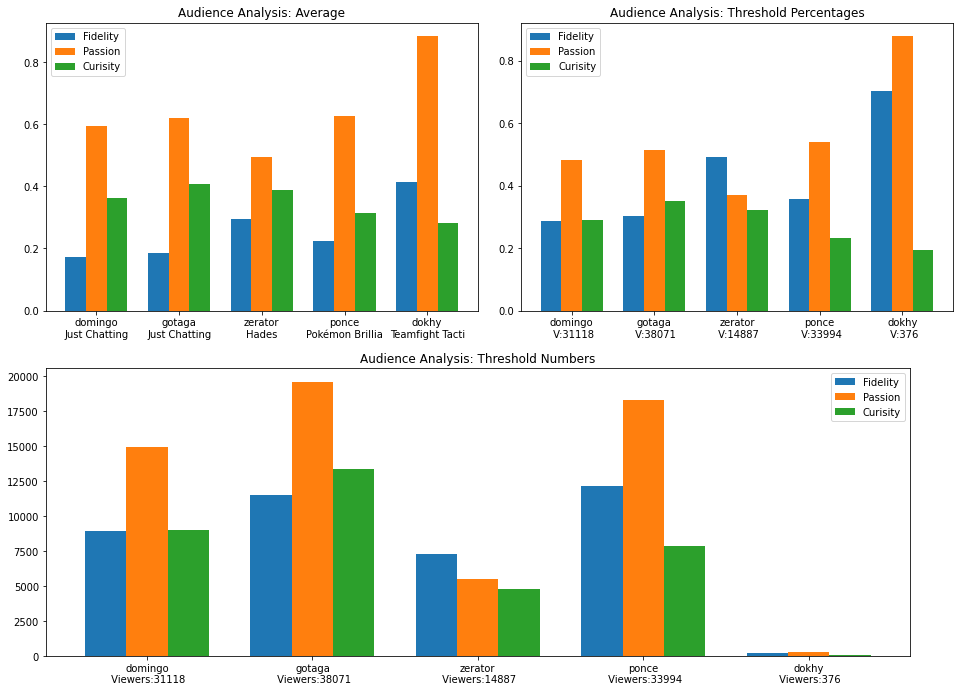

In [22]:
x = np.arange(len(compared_streamers))
width = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Audience Analysis: Average")
ax.bar(x-width, average_data[0], width = width, align='center', label="Fidelity")
ax.bar(x, average_data[1], width = width, align='center', label="Passion")
ax.bar(x+width, average_data[2], width = width, align='center', label="Curisity")
ax.set_xticks(x, minor=False) #Sets new labels positions
labels = [streamer+"\n"+subjects[streamer][0][:15] for streamer in compared_streamers]
ax.set_xticklabels(labels, minor=False)
ax.legend()

t = {"fidelity" : 0.2,
     "passion" : 0.6,
     "curiosity" : 0.4} #threshold
threshold_data = [
                [np.sum(np.array(data[streamer][q])>t[q])/len(data[streamer]["fidelity"]) for streamer in compared_streamers] 
                for q in data[compared_streamers[0]].keys()
                 ]

ax = fig.add_axes([1.1,0,1,1])
ax.set_title("Audience Analysis: Threshold Percentages")
ax.bar(x-width, threshold_data[0], width = width, align='center', label="Fidelity")
ax.bar(x, threshold_data[1], width = width, align='center', label="Passion")
ax.bar(x+width, threshold_data[2], width = width, align='center', label="Curisity")
ax.set_xticks(x, minor=False) #Sets new labels positions
labels = [streamer+"\n V:"+str(len(data[streamer]["fidelity"])) for streamer in compared_streamers]
ax.set_xticklabels(labels, minor=False)
ax.legend()


threshold_data = [
                [np.sum(np.array(data[streamer][q])>t[q]) for streamer in compared_streamers] 
                for q in data[compared_streamers[0]].keys()
                 ]

ax = fig.add_axes([0,-1.2,2,1])
ax.set_title("Audience Analysis: Threshold Numbers")
ax.bar(x-width, threshold_data[0], width = width, align='center', label="Fidelity")
ax.bar(x, threshold_data[1], width = width, align='center', label="Passion")
ax.bar(x+width, threshold_data[2], width = width, align='center', label="Curisity")
ax.set_xticks(x, minor=False) #Sets new labels positions
labels = [streamer+"\n Viewers:"+str(len(data[streamer]["fidelity"])) for streamer in compared_streamers]
ax.set_xticklabels(labels, minor=False)
ax.legend()
plt.show()


### Interpretation

These audience statistics give insight of the kind of viewers watching each streamer. The bound of the community seems more important for the smallest streamer "dokhy".

### General Analysis

In [23]:
N_viewers = 100
viewers = list(all_time_viewer_watch_lists.keys())
np.random.seed(12949302)
part_streamers_list = [all_time_viewer_watch_lists[viewer] for viewer in np.random.choice(viewers,N_viewers,False)]
part_streamers = list(set(sum(part_streamers_list, start=[])))

data = audience_stats(part_streamers, stream_time, all_time_viewer_watch_lists, subjects)

fidelity_red = sum([data[streamer]["fidelity"] for streamer in part_streamers], start=[])
fidelity_mean = np.mean(fidelity_red)
fidelity_std = np.std(fidelity_red)

passion_red = sum([data[streamer]["passion"] for streamer in part_streamers], start=[])
passion_mean = np.mean(passion_red)
passion_std =_std = np.std(passion_red)

curiosity_red = sum([data[streamer]["curiosity"] for streamer in part_streamers], start=[])
curiosity_mean = np.mean(curiosity_red)
curiosity_std = np.std(curiosity_red)


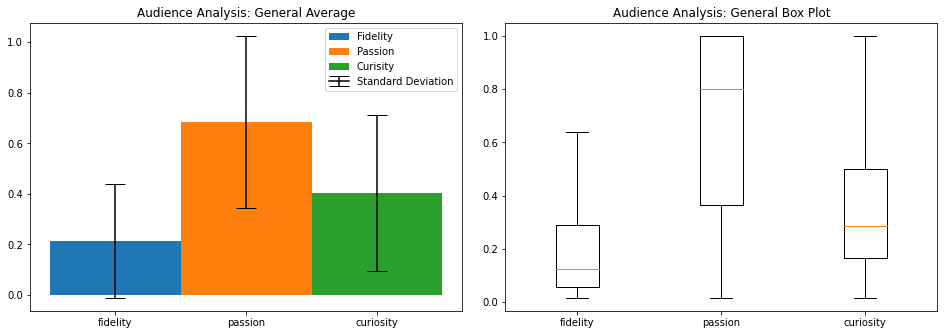

In [24]:
fig = plt.figure()
x=0
ax = fig.add_axes([0,0,1,1])
ax.set_title("Audience Analysis: General Average")
ax.bar(x-width, fidelity_mean, width = width, align='center', label="Fidelity")
ax.bar(x, passion_mean, width = width, align='center', label="Passion")
ax.bar(x+width, curiosity_mean, width = width, align='center', label="Curisity")
ax.errorbar(x-width, fidelity_mean, yerr=fidelity_std, c='k',capsize=10, label="Standard Deviation")
ax.errorbar(x, passion_mean, yerr=passion_std , c='k',capsize=10)
ax.errorbar(x+width, curiosity_mean, yerr=curiosity_std, c='k',capsize=10)

ax.set_xticks([x-width, x, x+width], minor=False) #Sets new labels positions
labels = data[part_streamers[0]].keys()
ax.set_xticklabels(labels, minor=False)
ax.legend()



ax = fig.add_axes([1.1,0,1,1])
ax.set_title('Audience Analysis: General Box Plot')
quantities = [fidelity_red, passion_red, curiosity_red]
ax.boxplot(quantities, showfliers=False)
ax.set_xticks([1,2,3], labels)
plt.show()

### Interpretation

Here we can justify/correct the choice for the threshold chosen before. Indeed the 3 metrics proposed are not distributed the same among viewers and streamers. They shouldn't be compare directly. The audience analysis still holds since we compared each metric individually between the streamers.

## Dynamical Graph

In [25]:
G_filtered = relevance_filter_directed(G)## Filter to keep relevant nodes for visualisation

563 nodes
24281 edges
[INFO] filtering nodes
173 nodes removed
1968 edges removed
[INFO] filtering edges
16851 edges removed


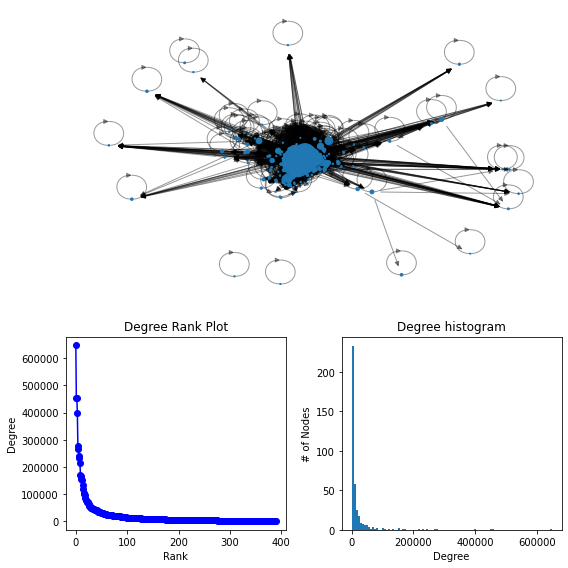

In [26]:
degree_sequence = sorted([d for n, d in G_filtered.degree(weight='change')], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(G_filtered, weight="change", seed=10396953)
_, watched_time = zip(*list(G_filtered.nodes("watched_time")))
scaled_watched_time=list(map(lambda x:x/500, watched_time))
nx.draw_networkx_nodes(G_filtered, pos, ax=ax0, node_size=scaled_watched_time)
nx.draw_networkx_edges(G_filtered, pos, ax=ax0, alpha=0.4)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(degree_sequence, bins=100)
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### Interpretation

We didn't extensively try to visualize this graph because the normalisation and the filter would have different meaning in this new graph. We just explored some parameters to be able to visualize the graph here.

Here some extreme nodes can have a self-loop with a high weight should they have stream a long time. This temporal behaviours can not be directly compared to the precedent behaviours.

### Further Use

The graph is by construction a means to predict future behaviour of a viewer only knowing where it is at a given time. For that the full network (not filtered) should be used.

- The edges are the jump probability
    - Take the edges that point to streaming nodes
    - Normalize the weights ("change") to get a probability
- It could be improved with viewer classification (fidelity, passion and curiosity)
    - To each user is associated a characteristic vector of size 3
    - Machine Learning Algorithm or Neural Networks can be used to predict the nex channel the user will watch
    - Expected behaviours:
        - Fidel are more likely to stay on the channel
        - Passion are more likely to jump to a channel of the same community
        - Curious are more likely to jump to any other channel
    
This give the ingredients to implement channel recommendation.